In [42]:
import pandas as pd
import scipy.special
import math
from matplotlib.pyplot import plot,scatter
import statistics
from sklearn.cluster import KMeans
from kneed import KneeLocator

In [56]:
years = range(2000, 2021)
leagues = ["nba", "mlb"] # TODO: add other leagues

def get_home_boost(total_pct, home_wins, home_games):
    prob = 0
    for wins in range(home_wins, home_games + 1):
        temp = scipy.special.binom(home_games, wins) * total_pct ** home_wins * (1-total_pct) ** (home_games - home_wins)        
        prob += temp
        
    return math.log(prob)

teamHomeBoosts={}
for league in leagues:
    teamHomeBoosts[league]={}
    for year in years:
        min_team = ""
        min_boost = 0
        
        standings = pd.read_csv("data/" + league + "/" + str(year) + ".csv") 
        for (team, home, road) in zip(standings["Team"], standings["Home"], standings["Road"]):
            [home_wins, home_losses] = [int(games) for games in home.split("-")]
            [road_wins, road_losses] = [int(games) for games in road.split("-")]

            total_wins = home_wins + road_wins
            total_games = total_wins + home_losses + road_losses

            total_pct = total_wins / total_games

            home_games = home_wins + home_losses
            home_pct = home_wins / home_games
            
            boost = get_home_boost(total_pct, home_wins, home_games)
            
            if(team not in teamHomeBoosts[league]):
                teamHomeBoosts[league][team]=[]
            teamHomeBoosts[league][team].append(boost)
            
            if boost < min_boost:
                min_team = team
                min_boost = boost
        print(league, year, min_team, min_boost)     
        
    

nba 2000 Indiana Pacers -5.80511463827075
nba 2001 Denver Nuggets -5.584793431365449
nba 2002 New Jersey Nets -4.444016767649159
nba 2003 Chicago Bulls -8.620230627143226
nba 2004 Dallas Mavericks -7.757497417601372
nba 2005 San Antonio Spurs -6.970570091337263
nba 2006 Orlando Magic -4.491720486818474
nba 2007 Golden State Warriors -5.6854126097084885
nba 2008 Utah Jazz -8.120960680710212
nba 2009 Utah Jazz -6.084120977243814
nba 2010 Charlotte Bobcats -5.799714816157004
nba 2011 Denver Nuggets -5.221992132606873
nba 2012 Utah Jazz -4.672668081620726
nba 2013 Denver Nuggets -8.030899955224543
nba 2014 Indiana Pacers -4.745391534633613
nba 2015 Golden State Warriors -4.51712130871859
nba 2016 San Antonio Spurs -6.042064542810159
nba 2017 Indiana Pacers -4.755360640485104
nba 2018 San Antonio Spurs -6.546983185786264
nba 2019 San Antonio Spurs -5.083659055945927
nba 2020 Philadelphia 76ers -8.969750876458228
mlb 2000 NYM -3.4389482986663387
mlb 2001 FLA -3.1084245358757148
mlb 2002 COL 

-1.3882999985574926
4
4
Consistent high home boosts: 
[-2.253017177936519, 0.027049022384828498] New Orleans/Oklahoma City Hornets
[-1.456865726827523, 0.8964202963949687] SFG
[-1.8854788511321505, 0.6539566408856704] STL
[-2.0240271813382957, 0.3393754366705654] NYY
[-1.7319598556909224, 0.6415558415005072] LAD
[-1.3949714691767994, 0.6541553421225434] TOR
[-1.55309031870017, 0.5730119632976514] ANA
Consistent low home boosts: 
[-1.2515261806971725, 1.9379147397133565] Seattle SuperSonics
[-0.30853182618379216, 3.4653283086876665] Brooklyn Nets
[-1.2455066129267514, 1.6692873043969327] CHW
[-0.9097474473514201, 1.4945265311797566] NYM
[-0.8997665226040985, 0.690771798564469] SEA
[-1.273894398239963, 0.6032187291533648] CLE
[-0.6678447575007007, 1.58552894470435] CIN
[-0.868279176601549, 2.1547231328190506] ARI
[-1.2203980293292587, 1.6041240528779317] FLA
[-0.2090351667154086, 1.3293120913857077] KCR
[-0.9308864572427297, 1.6874509818024874] SDP
[-1.1288300097214692, 3.050514332823729

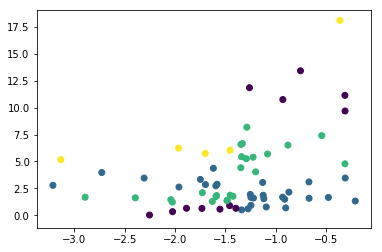

In [51]:
#Are there teams out of all leagues which consistently enjoy a larger home boost?
def computeOptimalClusters(testList):
    xList=[]
    yList=[]
    length=len(tuple(testList))
    list2=[]
    for i in range(1,length+1,1):
        cluster=KMeans(n_clusters=i)
        fit=cluster.fit(testList)
        list2.append([fit.inertia_, i])
    for i in list2:
        xList.append(i[1])
        yList.append(i[0])
    kn = KneeLocator(xList, yList, curve='convex', direction='decreasing')
    print(kn.knee)
    return(kn.knee)

def evaluateConsistency(testList):
    cluster=KMeans(n_clusters=computeOptimalClusters(testList), max_iter=10000, tol=.000000001,algorithm='auto')
    cluster.fit(testList)
    MeasureList=cluster.predict(testList)
    scatter([i[0] for i in testList],[i[1] for i in testList],c=MeasureList)
    minimum=min([index[1] for index in cluster.cluster_centers_])
    minIndex=[i for i in range(0,len(cluster.cluster_centers_)) if cluster.cluster_centers_[i][1]==minimum]
    selectList=[]
    for index,point in zip(MeasureList,testList):
        if(index==minIndex):
            selectList.append(point)
    return selectList

consistencyDict={}
consistencyList=[]
for league in teamHomeBoosts:
    for team in teamHomeBoosts[league]:
        if(len(teamHomeBoosts[league][team])>=2):
            variance=statistics.variance(teamHomeBoosts[league][team])
        
            mean=statistics.mean(teamHomeBoosts[league][team])
            if(mean<=0):
                consistencyDict[team]=[mean,variance]
                consistencyList.append([mean,variance])

meanSet=statistics.mean([item[0] for item in consistencyList])
print(meanSet)
greaterMeanList=[item for item in consistencyList if item[0]<meanSet]
lesserMeanList=[item for item in consistencyList if item[0]>meanSet]
consistentValuesLesser=evaluateConsistency(lesserMeanList)
consistentValuesGreater=evaluateConsistency(greaterMeanList)
print("Consistent high home boosts: ")
for i in consistentValuesGreater:
    print(i,list(consistencyDict.keys())[list(consistencyDict.values()).index(i)])
print("Consistent low home boosts: ")
for i in consistentValuesLesser:
    print(i,list(consistencyDict.keys())[list(consistencyDict.values()).index(i)])






-1.5797575830201112
4
3
Consistent high home boosts: 
[-2.3938628308658942, 1.625119396448424] Portland Trail Blazers
[-2.8921636843512273, 1.6806716632762007] Indiana Pacers
[-1.727826502685057, 2.1071482672013326] Detroit Pistons
[-2.0411223725913334, 1.455346721135553] Houston Rockets
[-2.253017177936519, 0.027049022384828498] New Orleans/Oklahoma City Hornets
[-2.025935107168257, 1.229622112724508] Oklahoma City Thunder
Consistent low home boosts: 
[-1.2515261806971725, 1.9379147397133565] Seattle SuperSonics
[-1.423583703574195, 1.7674342046787934] Toronto Raptors
[-0.30853182618379216, 3.4653283086876665] Brooklyn Nets
[-1.4811424582952113, 1.375558405537995] New Orleans Pelicans


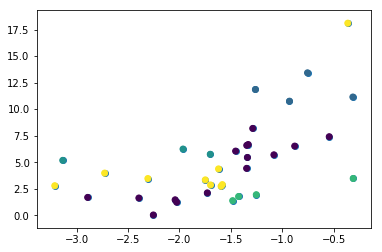

In [52]:
#which teams in the nba enjoy consistent higher and lower home boosts?
consistencyDict={}
consistencyList=[]

for team in teamHomeBoosts["nba"]:
    if(len(teamHomeBoosts["nba"][team])>=2):
        variance=statistics.variance(teamHomeBoosts["nba"][team])
        mean=statistics.mean(teamHomeBoosts["nba"][team])
        if(mean<=0):
            consistencyDict[team]=[mean,variance]
            consistencyList.append([mean,variance])
                                   
                                   
scatter([index[0] for index in consistencyList],[index[1] for index in consistencyList])

meanSet=statistics.mean([item[0] for item in consistencyList])
print(meanSet)
greaterMeanList=[item for item in consistencyList if item[0]<meanSet]
lesserMeanList=[item for item in consistencyList if item[0]>meanSet]
consistentValuesLesser=evaluateConsistency(lesserMeanList)
consistentValuesGreater=evaluateConsistency(greaterMeanList)
print("Consistent high home boosts: ")
for i in consistentValuesGreater:
    print(i,list(consistencyDict.keys())[list(consistencyDict.values()).index(i)])
print("Consistent low home boosts: ")
for i in consistentValuesLesser:
    print(i,list(consistencyDict.keys())[list(consistencyDict.values()).index(i)])


-1.1912113086695029
3
3
Consistent high home boosts: 
[-1.456865726827523, 0.8964202963949687] SFG
[-1.8854788511321505, 0.6539566408856704] STL
[-1.273894398239963, 0.6032187291533648] CLE
[-2.0240271813382957, 0.3393754366705654] NYY
[-1.7319598556909224, 0.6415558415005072] LAD
[-1.3949714691767994, 0.6541553421225434] TOR
[-1.55309031870017, 0.5730119632976514] ANA
[-1.2453177831865403, 0.929681329202398] PHI
[-1.3378963513909494, 0.5053258879639231] LAA
Consistent low home boosts: 
[-0.9097474473514201, 1.4945265311797566] NYM
[-0.8997665226040985, 0.690771798564469] SEA
[-0.6678447575007007, 1.58552894470435] CIN
[-0.868279176601549, 2.1547231328190506] ARI
[-0.2090351667154086, 1.3293120913857077] KCR
[-0.9308864572427297, 1.6874509818024874] SDP
[-1.1240957240071707, 1.867099813549856] PIT
[-1.1168859159458735, 1.54693381372938] CHC
[-1.0934013927136563, 0.7764876445639581] WSN
[-0.47590584641126166, 1.6603035676613447] MIA


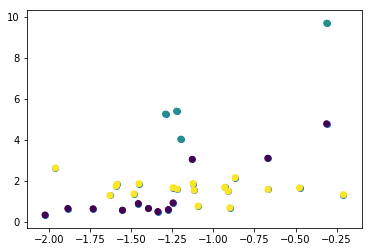

In [53]:
#which teams in the mlb enjoy consistent higher and lower home boosts?
consistencyDict={}
consistencyList=[]

for team in teamHomeBoosts["mlb"]:
    if(len(teamHomeBoosts["mlb"][team])>=2):
        variance=statistics.variance(teamHomeBoosts["mlb"][team])
        mean=statistics.mean(teamHomeBoosts["mlb"][team])
        if(mean<=0):
            consistencyDict[team]=[mean,variance]
            consistencyList.append([mean,variance])
                                   
                                   
scatter([index[0] for index in consistencyList],[index[1] for index in consistencyList])

meanSet=statistics.mean([item[0] for item in consistencyList])
print(meanSet)
greaterMeanList=[item for item in consistencyList if item[0]<meanSet]
lesserMeanList=[item for item in consistencyList if item[0]>meanSet]
consistentValuesLesser=evaluateConsistency(lesserMeanList)
consistentValuesGreater=evaluateConsistency(greaterMeanList)
print("Consistent high home boosts: ")
for i in consistentValuesGreater:
    print(i,list(consistencyDict.keys())[list(consistencyDict.values()).index(i)])
print("Consistent low home boosts: ")
for i in consistentValuesLesser:
    print(i,list(consistencyDict.keys())[list(consistencyDict.values()).index(i)])